In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

In [209]:
def f(s, eigvals):
    a = 1 + 2*(s)*eigvals
    b = np.log(a)
    b[0] *= -3/2
    b[1:] *= -1/2
    return eigvals[0] * np.exp(np.sum(b, axis=-1))

In [210]:
def int_f(eigvals):
    return scipy.integrate.quad(f, 0, np.inf, args=(eigvals,))[0]

/scratch/ag919/venv/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


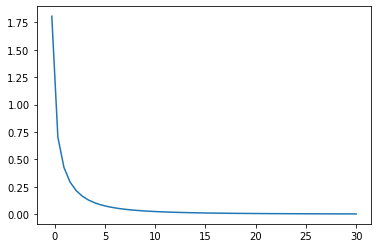

In [211]:
xs = np.linspace(-30, 30, 100)
plt.plot(xs, f(xs[:, None], np.array([1., 0.1, .1, .1, .1])))

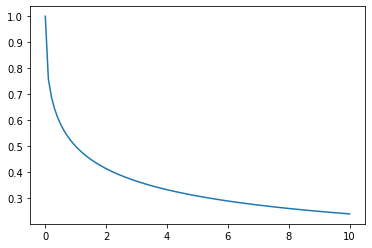

In [178]:
xs = np.linspace(0, 10, 100)
ys = []
for x in xs:
    ys.append(int_f(np.array([1., x])))
    
plt.plot(xs, ys)

In [213]:
def f_all(s, eigvals):
    a = np.log(1 + 2*s*eigvals)
    logdet = np.sum(a, axis=-1, keepdims=True)
    return eigvals * np.exp(-a -.5*logdet)

def corr(M):
    d = np.diag(M)
    return M * (d[:, None] * d)**-.5


def reluf(M):
    d = np.diag(M)
    c = np.clip(corr(M), -1., 1.)
    A = (np.sqrt(1 - c**2) + (np.pi - np.arccos(c))*c)/np.pi
    return A * (d[:, None] * d)**.5


def relu_batchnorm(S):
    G = np.eye(S.shape[0]) - 1/S.shape[0]
    vals, Q = np.linalg.eig(G@S@G)
    
    overall_relu = np.zeros_like(S)
    for i in range(overall_relu.shape[0]):
        for j in range(overall_relu.shape[1]):
            Q_ = Q[[i, j], :]
            overall_relu[i, j], tol = scipy.integrate.quad(
                lambda x: reluf(Q_ * f_all(x, vals) @ Q_.T)[0, 0],
                0, np.inf)


In [214]:
S = np.random.randn(10, 10)
S = S@S.T / 15


G = np.eye(len(S)) - 1/len(S)
vals, Q = np.linalg.eig(G@S@G)

xs = [0., 0.1, 1., 10., 100.]


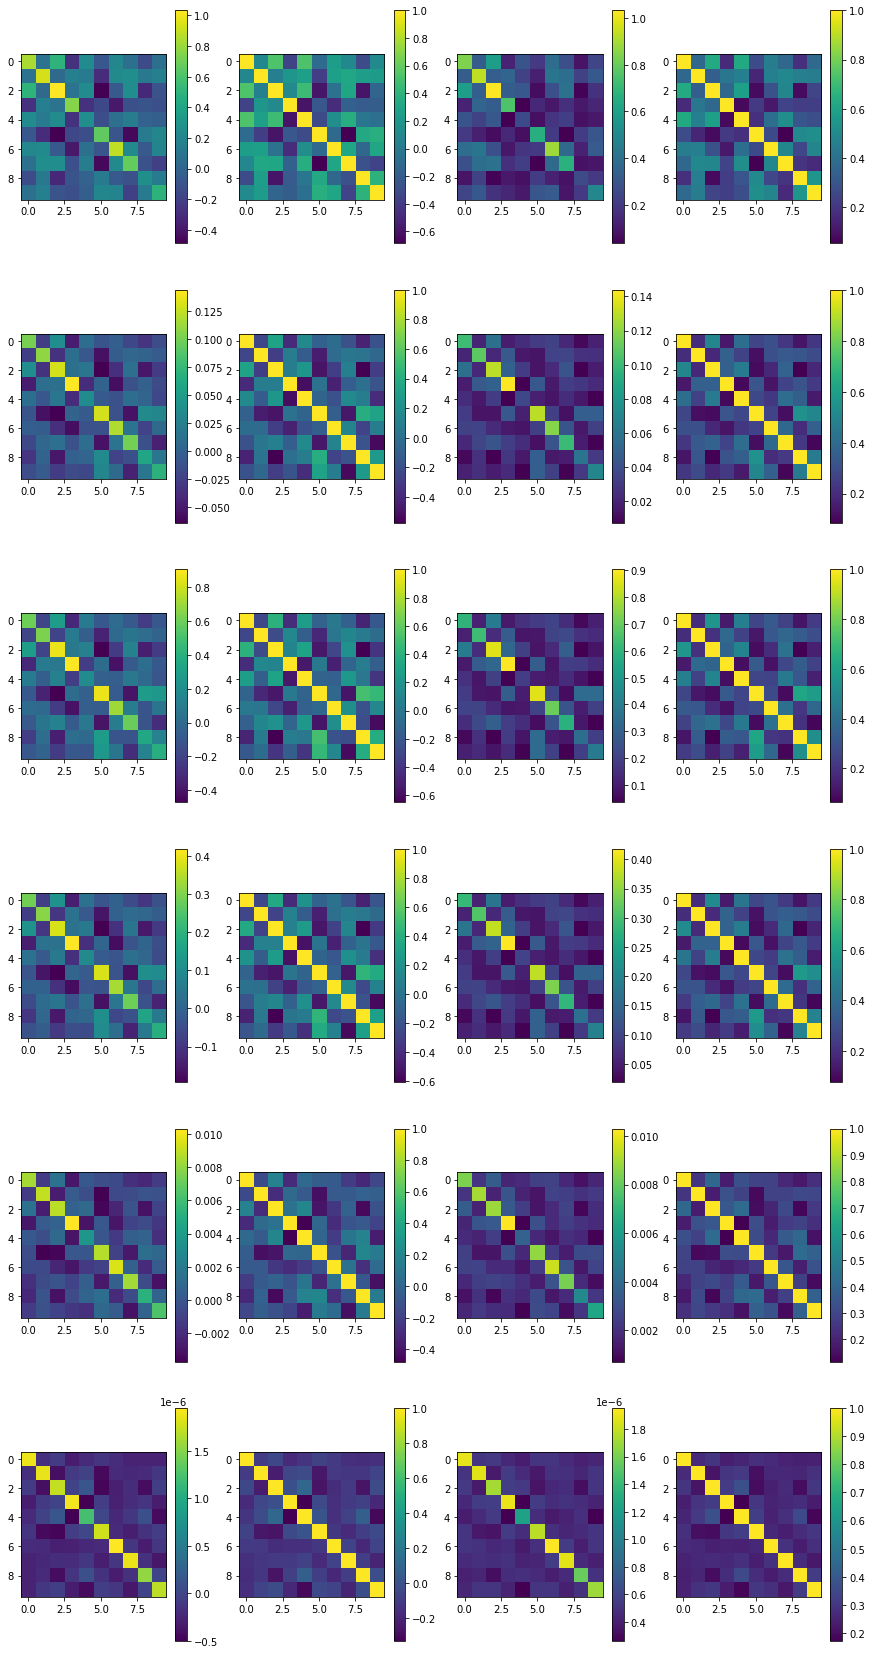

In [215]:
fig, axes = plt.subplots(len(xs)+1, 4, figsize=(15, 30))

for (x, ax) in zip(xs, axes[2:]):
    M = Q * f_all(x, vals) @ Q.T
    im = ax[0].imshow(M)
    fig.colorbar(im, ax=ax[0])
    im = ax[1].imshow(corr(M))
    fig.colorbar(im, ax=ax[1])
    im = ax[2].imshow(reluf(M))
    fig.colorbar(im, ax=ax[2])
    im = ax[3].imshow(corr(reluf(M)))
    fig.colorbar(im, ax=ax[3])
    
    
im = axes[0, 0].imshow(S)
fig.colorbar(im, ax=axes[0, 0])
im =axes[0, 1].imshow(corr(S))
fig.colorbar(im, ax=axes[0, 1])
im = axes[0, 2].imshow(reluf(S))
fig.colorbar(im, ax=axes[0, 2])
im =axes[0, 3].imshow(corr(reluf(S)))
fig.colorbar(im, ax=axes[0, 3])


overall = np.zeros_like(Q)
for i in range(overall.shape[0]):
    for j in range(overall.shape[1]):
        overall[i, j], tol = scipy.integrate.quad(lambda x: Q[i] * f_all(x, vals) @ Q[j].T, 0, np.inf)

im = axes[1, 0].imshow(overall)
fig.colorbar(im, ax=axes[1, 0])
im =axes[1, 1].imshow(corr(overall))
fig.colorbar(im, ax=axes[1, 1])

overall_relu = np.zeros_like(Q)
for i in range(overall_relu.shape[0]):
    for j in range(overall_relu.shape[1]):
        overall_relu[i, j], tol = scipy.integrate.quad(lambda x: reluf(Q * f_all(x, vals) @ Q.T)[i, j], 0, np.inf)
        
        
im = axes[1, 2].imshow(overall_relu)
fig.colorbar(im, ax=axes[1, 2])
im =axes[1, 3].imshow(corr(overall_relu))
fig.colorbar(im, ax=axes[1, 3])

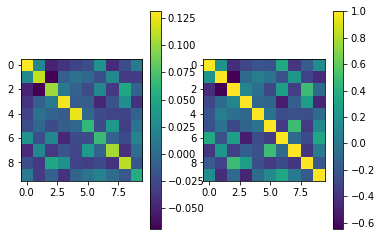

In [156]:
overall = np.zeros_like(Q)
for i in range(overall.shape[0]):
    for j in range(overall.shape[1]):
        overall[i, j], tol = scipy.integrate.quad(lambda x: Q[i] * f_all(x, vals) @ Q[j].T, 0, np.inf)
plt.subplot(121)
plt.imshow(overall)
plt.colorbar()

plt.subplot(122)
plt.imshow(corr(overall))
plt.colorbar()

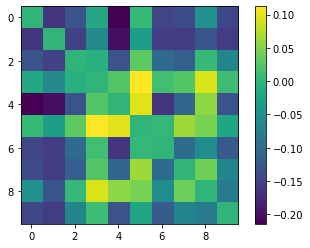

In [217]:
plt.imshow(corr(overall_relu) - corr(reluf(S)))
plt.colorbar()

In [218]:
corr(overall_relu).mean(), corr(reluf(S)).mean()


(0.3495189646021849, 0.4030458318199442)

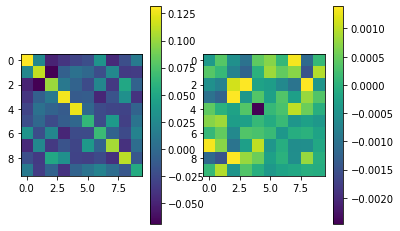

In [155]:
plt.subplot(121)
plt.imshow(overall)
plt.colorbar()

plt.subplot(122)
a = (Q * f_all(0.012, vals) @ Q.T)
plt.imshow(overall - (overall*a).sum() / (a*a).sum() * a)
plt.colorbar()

In [139]:
a = S

In [129]:
a = (Q * f_all(0.01, vals) @ Q.T)